In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
from PIL import Image

from sklearn.ensemble import AdaBoostClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn.datasets import make_moons, make_classification
from sklearn.tree import DecisionTreeClassifier

In [101]:
plt.rc('font', family = 'malgun gothic')
warnings.filterwarnings(action = 'ignore')
plt.rcParams['axes.unicode_minus'] = False

Text(0.5, 1.0, '사용할 예제 데이터')

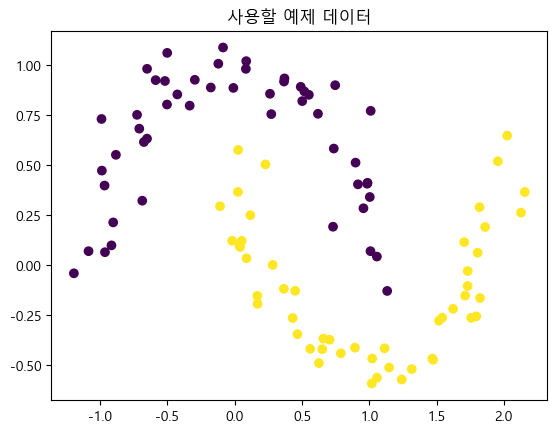

In [130]:
X,Y = make_moons(n_samples = 100, noise = 0.1, random_state = 2023)

plt.scatter(X[:,0], X[:,1], c = Y)
plt.title("사용할 예제 데이터")

# Adaptive Boost 모델 구현 

* n 번째 weak learner 의 데이터 선택 과정과 각 weak learner 별 가중치 계산 과정에 대해 구현해봤습니다.

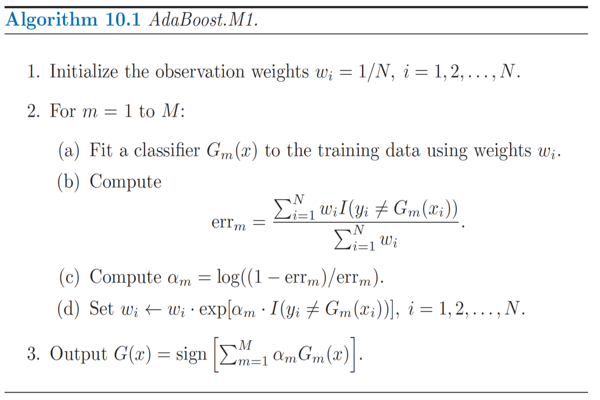

In [8]:
Image.open('C:/Users/whileduck/Dropbox/사진/adaboosting algorythm.png').resize((600,400))

Adboost에서는 약한 학습자와의 선형 결합 과정을 통해 여러 약한 학습자의 예측을 결합하여 보다 정확한 모델을 생성합니다.

첫 번째 단계에서 훈련 데이터의 가중치를 초기화합니다. 각 데이터 처음에 동일한 가중치가 부여됩니다. 첫 가중치는 1 / 데이터의 갯수 입니다.

두 번재 단계에서는 가지가 하나인 Stump 를 가지고 (오분류율이 0.5 이하인) 데이터 셋을 분류합니다.

세 번재 단계에서 오분류 된 데이터에 대하여 가중치를 업데이트 합니다.

위에서 설명하고 있는 alpha 값을 가지고, weight * exp^alpha * I 로 업데이트 합니다.

네 번재 단계에서는 원 데이터 샘플만큼의 랜덤한 0과 1사이의 난수를 생성한 후 가중치의 값에 비례하여 새로운 데이터 샘플을 복원 추출합니다.

이런 과정을 통해 다음 Stump 에 적용 될 복원추출된 데이터셋은 이전 Stump 에서 오분류한 데이터에 집중된 데이터를 얻게 됩니다.

이 과정을 반복하며 n 개의 Stump, n-1 개의 새로운 데이터셋, 입력 값에 대한 n 개의 출력값, n 개의 모델의 alpha 값이 만들어집니다.

최종 출력값은 입력 변수 Xi 가 들어왔을 때 1:1 대응되는 n 개의 Stump 의 결과값 * n 개의 alpha 값의 총합을 구하고, 총합 값이 0 이하면 Negative, 1 이상이면 Positive로 예측합니다.

In [131]:
n_estimator = 9
eta = 1 # 학습률
model_list = []
predict_list = []
error_list = []
alpha_list = []
weight_list = []
X_list = []
Y_list = []
idx_list = []
n = X.shape[0] #X 의 행 갯수

weight = np.array([1/n] * n) # 초기 weight
idx = list(range(X.shape[0]))

k = len(np.unique(Y)) # Y class 갯수

for num in range(n_estimator+1):
    
    idx_list.append(idx)
    X_list.append(X)
    Y_list.append(Y)
    
    tree = DecisionTreeClassifier(max_depth = 1) # stump 가지 생성
    tree.fit(X,Y)
    
    
    
        
    predict = np.array(tree.predict(X))
    
    incorrect = predict != Y # 예측값과 실제값이 다르면 True,다르면 False 로 생성
    
     # X의 행의 갯수만큼 동일한 가중치 생성 (1/ number of samples)
    
    error = np.sum(weight[incorrect]/ np.sum(weight)) # 전체 Weight 중 실제값과 다른 가중치의 비율 계산
    
    if error == 0: # weak learner 의 error 가 0이라면 ealry stop
        
        print(num, '번째 tree 에서 stop')
        
        break 
    
    alpha = eta * 1/2 * np.log((1 - error)/ error) + np.log(k - 1)
    
    predict_list.append(predict)
    error_list.append(error)
    alpha_list.append(alpha)
    model_list.append(tree)
    
    
    # 가중치 업데이트 하기
    
    new_weight = weight.copy()
    
    new_weight = new_weight * np.exp(alpha * incorrect) # 실제값과 다른 예측값에 대해서만 alpha 값을 곱해준다.
                                                        # 이렇게 되면 맞춘 값에 대한 가중치의 변화는 없고, 맞추지 못한 값에 대한 가중치는 커진다.
    
    weight_list.append(new_weight)
    
    idx = random.choices(range(n), weights = new_weight, k = n) # 원본 데이터 갯수와 동일한 샘플링 인덱스를 추출한다. 
                                                                # 가중치만큼의 비율을 조정하여, 맞추지 못한 값에 대한 인덱스는 더욱 많이 추출 된다.
                                                                
                                                                
    X = np.array(pd.DataFrame(X).iloc[idx,:].reset_index(drop = True)) # 틀린 데이터를 더욱 많이 복원 추출한 새로운 데이터 셋을 n+1 번째 tree 에 fitting 시킬 수 있도록 데이터셋 준비
    Y = Y[idx]
    weight = np.array([1/n] * n)
    


# Weak Learner 의 데이터 수집 과정 시각화 

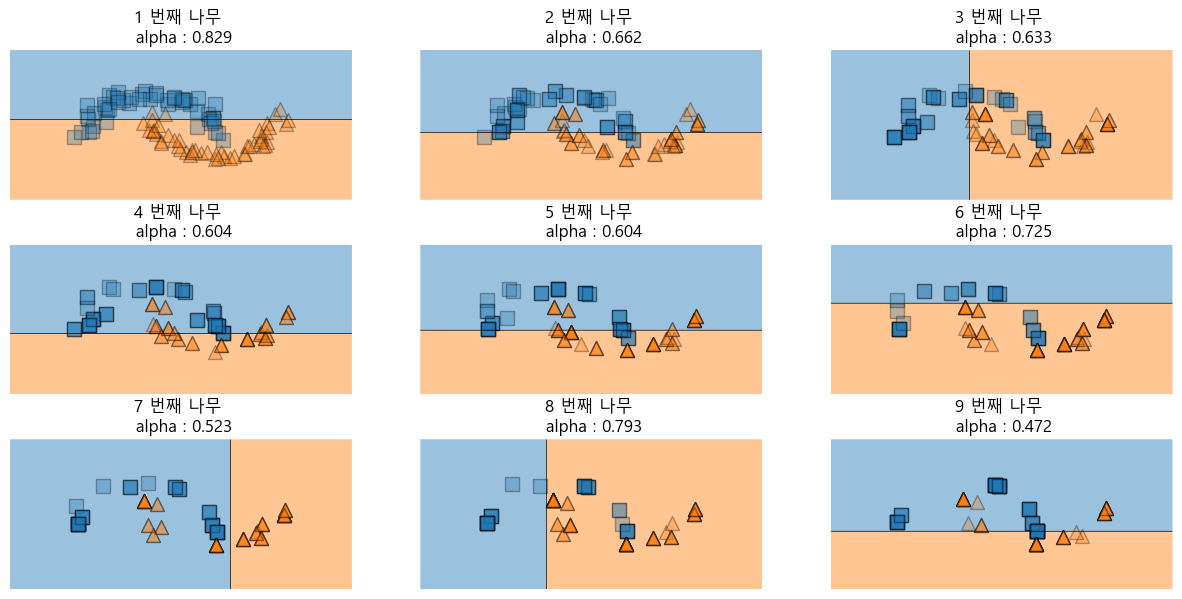

In [132]:
plt.figure(figsize = [15,7])

plt.subplots_adjust(hspace = 0.3)

for num in range(n_estimator):
    
    plt.subplot(3,3,num+1)

    
    tree = DecisionTreeClassifier(max_depth = 1)
    
    X_new = X_list[num] # estimator 별로 복원추출한 데이터 리스트, 0번째 데이터는 원본데이터를 의미하고 점점 이전 stump 에서 틀렸던 데이터셋을 많이 가지고있다.
    Y_new = Y_list[num]
    
    tree.fit(X_new,Y_new)
    
    alpha = round(alpha_list[num],3) # 각 estimator 별 alpha 값. 각 estimator 분류 결과에 곱해지는 스칼라값으로 각 estimaor 의 발언권정도로 이해하면 된다. 

    
    plot_decision_regions(X_new,Y_new, clf = tree, legend = None, scatter_kwargs={'alpha': 0.3, 's':100}) 
    plt.xticks([],[])
    plt.yticks([],[])
    plt.title(f'{num+1} 번째 나무 \n alpha : {alpha}')

* 각 n 번째 stump에서 사용하는 데이터셋은 n-1 번째 stump 에서 맞추지 못한 데이터셋의 가중치를 고려하여, 원본 사이즈 만큼의 랜덤한 데이터셋을 복원추출합니다.

* 이렇게 되면 각 n 번째 stump 는 n-1 번째 stump 에서 맞추지 못한 데이터셋을 더욱 많이 가지고 있는 데이터셋을 가지고 분할하기 때문에 이전에 맞추지 못한 데이터를 더욱 더 잘 분류 하기 위해 분할합니다.

* estimaor 가 늘어 날 수록 데이터가 틀린 데이터를 더욱 많이 복원 추출하며 틀렸던 데이터에 집중하고 있는 모습을 볼 수 있습니다.